In [339]:
import pandas as pd
import numpy as np
# import warnings
# warnings.filterwarnings("ignore")

## Config

In [340]:
exp_type = "cv3" # cv1, cv2, cv3, cell-adapted
target_cell = ["K562"]
neg_sam_ratio = 1 # N: 1:N

In [341]:
# To Fix
weight_decay = 0.001

## Read Data

In [342]:
def parse_text_file(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            elements = line.strip().split()
            
            if not elements:
                continue
                
            key = int(elements[0])
            # if key not in ncbi_to_scgpt:
            #     continue
            # key = ncbi_to_scgpt[key]
            features = list(map(float, elements[1:]))
            
            data_dict[key] = features
    return data_dict

In [343]:
import pickle

# Outside Embeddings
with open('./data/scgpt_emb.pkl', 'rb') as f:
    scgpt_emb = pickle.load(f)
with open('./data/geneformer_gene_embs.pkl', 'rb') as f:
    geneformer_emb = pickle.load(f)
with open('../data/GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle', 'rb') as f:
    genept_emb = pickle.load(f)
with open("./data/kg_embeddings_64.pkl","rb") as f:
    kg_info = pickle.load(f)
with open("./data/protein_emb.pkl", "rb") as f:
    protein_emb = pickle.load(f)
ppi_emb = parse_text_file('./data/ppi_emb.txt')


# Protein info: find ncbi index -> scgpt index
protein_info = pd.read_csv('./data/protein_info.csv')

# Gene Expression
gene_expression = pd.read_csv(
    './data/CCLE_normalized_expression.txt',  
    sep='\s+',
    header=0,
    index_col=0,
    engine='python'
)

# maps
scgpt_gene2idx = pd.read_csv('./data/scgpt_gene2idx.txt', sep='\t', header=None)
dbid2name = pd.read_csv('./data/dbid2name.csv')['name'].to_dict()


# SL data
# sl_train = pd.read_csv('./data/sl_train.csv')
sl_raw = pd.read_csv('../data/SLKB_rawSL.csv')

In [344]:
print(gene_expression)

            CORL24      HSC3     KMS11    C2BBE1   CORL311     HCC33  \
gene_ids                                                               
A1BG      2.849391 -0.808122 -0.407499  0.324076  0.232819  2.182273   
A1CF     -0.224682 -2.365709 -0.920761  4.670182 -1.548158 -1.542082   
A2M      -5.040961 -5.817617 -4.175663 -2.158997 -3.050761 -3.549381   
A2ML1    -2.014530 -2.013579 -1.871127 -2.063357 -1.202725 -0.811257   
A3GALT2  -2.023289 -5.817617 -5.817617 -5.029529 -3.707306 -2.841032   
...            ...       ...       ...       ...       ...       ...   
ZYG11A    3.454790  2.938309  5.636054  2.353795 -1.390345  1.153612   
ZYG11B    5.532251  4.766173  4.388785  5.133387  5.755072  5.549571   
ZYX       1.485196  6.646921  6.496448  8.212980 -2.068951 -1.149104   
ZZEF1     6.491424  6.010369  6.477038  5.676353  6.863211  6.265765   
ZZZ3      6.020686  6.354494  5.089011  4.809345  5.746466  6.352993   

              5637   CORL279     DMS53     JHOS2  ...   NCIH841

## Process Loaded Data

In [345]:
# map: gene name & scgpt id 
gene2idx_dict = dict(zip(scgpt_gene2idx[0], scgpt_gene2idx[1].astype(int)))
gene_2name_dict = dict(zip(scgpt_gene2idx[1].astype(int), scgpt_gene2idx[0]))

# Protein info: name -> scgp id
gene_names = protein_info['Gene names'].str.split().apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
mapped_ids = gene_names.map(gene2idx_dict)
protein_info['scGPT_id'] = mapped_ids.astype('Int64')
protein_info['scGPT_name'] = protein_info['scGPT_id'].map(gene_2name_dict)

# map: NCBI id-> scgp id
ncbi_to_scgpt = dict(zip(protein_info['NCBI_gene_id'], protein_info['scGPT_id']))

# Geneformer: key: name -> scgpt id
origin_len = len(geneformer_emb)
geneformer_emb = {gene2idx_dict[k]:v  for k, v in geneformer_emb.items() if k in gene2idx_dict}

# GenePT: key: name -> scgpt id
origin_len = len(genept_emb)
genept_emb = {gene2idx_dict[k]:v  for k, v in genept_emb.items() if k in gene2idx_dict}

# PPI: key: NCBI id -> scgpt id
origin_len = len(ppi_emb)
ppi_emb = {ncbi_to_scgpt[k]:v  for k, v in ppi_emb.items() if k in ncbi_to_scgpt}

# KG: reindexed id -> dbid -> name -> scgpt id
kg_emb_list = kg_info['embeddings']
kg_id2entity = kg_info['id2entity']
kg_id_list = pd.DataFrame(range(len(kg_emb_list)), columns=['reindexed_id'])
kg_id_list['entity_id'] = kg_id_list['reindexed_id'].map(kg_id2entity).astype('Int64')
kg_id_list['name'] = kg_id_list['entity_id'].map(dbid2name)
kg_id_list['scgpt_id'] = kg_id_list['name'].map(gene2idx_dict).astype('Int64')
kg_emb = {id:kg_emb_list[i] for i, id in kg_id_list['scgpt_id'].dropna().items() }

# Gene Expression
gene_expression.index = gene_expression.index.map(gene2idx_dict).astype("Int64")



In [346]:
# SL
sl_raw.loc[sl_raw['SL_or_not']=='Not SL','label'] = 0
sl_raw.loc[sl_raw['SL_or_not']=='SL','label'] = 1
sl_raw['label'] = sl_raw['label'].astype('Int64')

sl_raw['geneA_scGPT_id'] = sl_raw['gene_1'].map(gene2idx_dict).astype('Int64')
sl_raw['geneB_scGPT_id'] = sl_raw['gene_2'].map(gene2idx_dict).astype('Int64')


In [347]:
def select_genes_until_coverage(df, coverage_threshold=0.8):

    selected_genes = set([])

    covered_mask = df['geneA_scGPT_id'].isin(selected_genes) & df['geneB_scGPT_id'].isin(selected_genes)
    current_coverage = covered_mask.mean()
    coverage_history = [current_coverage]
    
    all_genes = set(df['geneA_scGPT_id']).union(set(df['geneB_scGPT_id'])) - selected_genes
    
    while current_coverage < coverage_threshold and all_genes:
        best_gene = None
        best_gain = 0
        best_gene = next(iter(all_genes))
        
        selected_genes.add(best_gene)
        all_genes.remove(best_gene)
        
        covered_mask = df['geneA_scGPT_id'].isin(selected_genes) & df['geneB_scGPT_id'].isin(selected_genes)
        current_coverage = covered_mask.mean()
        coverage_history.append(current_coverage)
        
        if current_coverage >= coverage_threshold:
            break
    
    return selected_genes, coverage_history

In [348]:
from sklearn.model_selection import KFold, GroupKFold, LeaveOneGroupOut
if exp_type[:2] == "cv":
    sl_raw = sl_raw[sl_raw['cell_line_origin'].isin(target_cell)].dropna()
    if exp_type == "cv1":
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for train_idx, test_idx in kf.split(sl_raw):
            sl_train = sl_raw.iloc[train_idx]
            sl_test = sl_raw.iloc[test_idx]
    elif exp_type == "cv2":
        selected_genes, _ = select_genes_until_coverage(sl_raw, 0.8)
        in_ref1 = sl_raw['geneA_scGPT_id'].isin(selected_genes)
        in_ref2 = sl_raw['geneB_scGPT_id'].isin(selected_genes)

        sl_test = sl_raw[in_ref1 ^ in_ref2]
        sl_train = sl_raw[in_ref1 & in_ref2] 

            
    elif exp_type == "cv3":
        selected_genes, _ = select_genes_until_coverage(sl_raw, 0.5)
        in_ref1 = sl_raw['geneA_scGPT_id'].isin(selected_genes)
        in_ref2 = sl_raw['geneB_scGPT_id'].isin(selected_genes)

        sl_test = sl_raw[~in_ref1 & ~in_ref2] 
        sl_train = sl_raw[in_ref1 & in_ref2]

elif exp_type == "cell-adapted":
    sl_train = sl_raw[~sl_raw['cell_line_origin'].isin(target_cell)]
    sl_test = sl_raw[sl_raw['cell_line_origin'].isin(target_cell)]
    
print("\nTrain:\n", sl_train)
print("Test:\n", sl_test)


初始覆盖率: 0.00%

Train:
         Unnamed: 0      gene_pair  study_origin cell_line_origin  gene_1  \
10721        10722      PIM1|PIM2      28319085             K562    PIM1   
10727        10728     DBH|TPSAB1      28319085             K562     DBH   
10731        10732    LCK|PIK3C2B      28319085             K562     LCK   
10732        10733  FABP4|SLC16A8      28319085             K562   FABP4   
10734        10735    CDKN1A|TOP1      28319085             K562  CDKN1A   
...            ...            ...           ...              ...     ...   
206712      206713    RAE1|ZNF598      30033366             K562  ZNF598   
206713      206714   TGIF2|ZNF598      30033366             K562  ZNF598   
206714      206715      NEMF|RAE1      30033366             K562    NEMF   
206715      206716     NEMF|TGIF2      30033366             K562    NEMF   
206716      206717     RAE1|TGIF2      30033366             K562    RAE1   

         gene_2 SL_or_not   SL_score  statistical_score  SL_score

In [349]:


sl_train = sl_train[['geneA_scGPT_id','geneB_scGPT_id', 'label', 'cell_line_origin']]
sl_train = sl_train.dropna()

sl_test = sl_test[['geneA_scGPT_id','geneB_scGPT_id', 'label', 'cell_line_origin']]
sl_test = sl_test.dropna()

## Negative Sample

In [350]:
import pandas as pd
import numpy as np
import random

def reshape_neg_sample(df, ratio):
    df = df.copy()
    
    positive_df = df[df['label'] == 1].reset_index(drop=True)
    
    if positive_df.empty:
        return pd.DataFrame(columns=['geneA_scGPT_id', 'geneB_scGPT_id', 'label', 'cell_line_origin'])
    
    result_dfs = []
    
    cell_lines = df['cell_line_origin'].unique()
    
    for cell_line in cell_lines:
        cell_line_df = df[df['cell_line_origin'] == cell_line]
        
        cell_positive_df = positive_df[positive_df['cell_line_origin'] == cell_line]
        
        if cell_positive_df.empty:
            continue

        genes_1 = cell_line_df['geneA_scGPT_id'].unique()
        genes_2 = cell_line_df['geneB_scGPT_id'].unique()
        all_genes = sorted(set(genes_1) | set(genes_2))

        existing_pairs = set()
        for _, row in cell_line_df.iterrows():
            gene_1, gene_2 = sorted([row['geneA_scGPT_id'], row['geneB_scGPT_id']])
            existing_pairs.add((gene_1, gene_2))
        
        n_positive = len(cell_positive_df)
        n_negative = int(n_positive * ratio)
        
        all_neg_pairs = [(i,j) for i in all_genes for j in all_genes if i!= j and (i,j) not in existing_pairs]
        
        negative_pairs = random.sample(all_neg_pairs,n_negative)
        negative_samples = []
        
        for pair in negative_pairs:
            gene_1, gene_2 = pair
            negative_samples.append({
                'geneA_scGPT_id': gene_1,
                'geneB_scGPT_id': gene_2,
                'label': 0,
                'cell_line_origin': cell_line
            })
            
        
        negative_df = pd.DataFrame(negative_samples)
        
        cell_result_df = pd.concat([cell_positive_df, negative_df], ignore_index=True)
        result_dfs.append(cell_result_df)
    
    if not result_dfs:
        return pd.DataFrame(columns=['geneA_scGPT_id', 'geneB_scGPT_id', 'label', 'cell_line_origin'])
    
    result_df = pd.concat(result_dfs, ignore_index=True)
    return result_df


print(sl_train[sl_train['label'] == 1])

sl_train = reshape_neg_sample(sl_train, neg_sam_ratio)
sl_train = sl_train.sample(frac=1).reset_index(drop=True)
print(sl_train)
sl_test = reshape_neg_sample(sl_test, neg_sam_ratio)
sl_test = sl_test.sample(frac=1).reset_index(drop=True)
print(sl_test)

        geneA_scGPT_id  geneB_scGPT_id  label cell_line_origin
10721            19580           19581      1             K562
10727             7386           33979      1             K562
10731            13277           19559      1             K562
10732             8832           31319      1             K562
10734             4536           33901      1             K562
...                ...             ...    ...              ...
206311            8642           31556      1             K562
206662              68           19616      1             K562
206689           21551           32915      1             K562
206696           32915           33353      1             K562
206714           17649           20905      1             K562

[742 rows x 4 columns]
      geneA_scGPT_id  geneB_scGPT_id  label cell_line_origin
0              16940           20549      1             K562
1              12619           16930      0             K562
2              35387            2691 

## Data Statics

In [351]:

# SL raw
counts = sl_raw['cell_line_origin'].value_counts()
sl_raw_cell_list = counts.index.tolist()
print(sl_raw_cell_list)
print(counts)
sl_pos = sl_raw[sl_raw["label"]==1]
counts = sl_pos['cell_line_origin'].value_counts()
print(counts)
all_gene = pd.concat([sl_raw['gene_1'],sl_raw['gene_2']])
count_a = all_gene.value_counts()
print(len(count_a))

['K562']
cell_line_origin
K562    106707
Name: count, dtype: int64
cell_line_origin
K562    1387
Name: count, dtype: int64
611


In [352]:
# # 查看映射结果
# print(f"成功映射的基因数量: {protein_info['scGPT_id'].notna().sum()}")
# print(f"总基因数量: {len(protein_info)}")
# print(f"映射成功率: {protein_info['scGPT_id'].notna().sum() / len(protein_info):.2%}")

# # 查看映射结果
# print(f"成功映射的基因数量: {len(geneformer_emb)}")
# print(f"总基因数量: {origin_len}")
# print(f"映射成功率: {len(geneformer_emb) / origin_len:.2%}")

# # 查看映射结果
# print(f"成功映射的基因数量: {len(kg_emb)}")
# print(f"总基因数量: {len(kg_emb_list)}")
# print(f"映射成功率: {len(kg_emb) / len(kg_emb_list):.2%}")

# # 保留所有数据
# # sl_filtered = sl_train.copy()
# print(f"总数据量: {len(sl_filtered)}")
# print(f"geneA映射缺失: {sl_filtered['geneA_scGPT_id'].isna().sum()}")
# print(f"geneB映射缺失: {sl_filtered['geneB_scGPT_id'].isna().sum()}")

# print(sl_train_new)

# print(sl_train_new)
# sl_filtered = sl_train_new
# print(f"总数据量: {len(sl_filtered)}")
# print(f"geneA映射缺失: {sl_filtered['geneA_scGPT_id'].isna().sum()}")
# print(f"geneB映射缺失: {sl_filtered['geneB_scGPT_id'].isna().sum()}")

### Protein Sequence Embedding

In [353]:
# from tqdm import tqdm
# import numpy as np
# import torch
# import pickle
# import os

# if os.path.exists("./data/protein_emb.pkl"):
#     with open("./data/protein_emb.pkl", "rb") as f:
#         protein_emb = pickle.load(f)
# else:
#     tokenizer = AutoTokenizer.from_pretrained("pretrained/esm2_t6_8M_UR50D_tokenizer")
#     model = EsmModel.from_pretrained("pretrained/esm2_t6_8M_UR50D_model").cuda()
#     model.eval()

#     protein_sequences = protein_info['Sequence'].tolist()

#     protein_emb = np.zeros((0, model.config.hidden_size))

#     protein_emb_batch_size = 4 
#     max_seq_length = 1024 

#     for i in tqdm(range(0, len(protein_sequences), protein_emb_batch_size)):
#         batch = protein_sequences[i:i + protein_emb_batch_size]
        
#         inputs = tokenizer(
#             batch, 
#             return_tensors="pt", 
#             padding=True, 
#             truncation=True, 
#             max_length=max_seq_length
#         )
#         inputs = {k: v.cuda() for k, v in inputs.items()}
        
#         with torch.no_grad():
#             outputs = model(**inputs)
        
#         protein_emb_batch = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        
#         if protein_emb.size == 0:
#             protein_emb = protein_emb_batch
#         else:
#             protein_emb = np.concatenate((protein_emb, protein_emb_batch), axis=0)
        

#         del inputs, outputs
#         torch.cuda.empty_cache()
#     protein_emb = dict(zip(protein_info["scGPT_id"], protein_emb))
#     protein_emb = {int(k):v for k,v in protein_emb.items() if not pd.isna(k)}
#     with open("./data/protein_emb.pkl", "wb") as f:
#         pickle.dump(protein_emb, f)

### PPI Embedding

In [354]:
# import networkx as nx
# from node2vec import Node2Vec
# ppi = pd.read_csv('./data/ppi.csv')
# G = nx.from_pandas_edgelist(ppi, 'geneA_ID', 'geneB_ID')
# node2vec = Node2Vec(G, dimensions=64)
# model = node2vec.fit()
# ppi_emb = {node: model.wv[node] for node in G.nodes()}

## Cell Embedding

In [355]:
print(gene_expression)
# print(genept_emb)

            CORL24      HSC3     KMS11    C2BBE1   CORL311     HCC33  \
gene_ids                                                               
0         2.849391 -0.808122 -0.407499  0.324076  0.232819  2.182273   
2        -0.224682 -2.365709 -0.920761  4.670182 -1.548158 -1.542082   
3        -5.040961 -5.817617 -4.175663 -2.158997 -3.050761 -3.549381   
5        -2.014530 -2.013579 -1.871127 -2.063357 -1.202725 -0.811257   
8        -2.023289 -5.817617 -5.817617 -5.029529 -3.707306 -2.841032   
...            ...       ...       ...       ...       ...       ...   
36561     3.454790  2.938309  5.636054  2.353795 -1.390345  1.153612   
36562     5.532251  4.766173  4.388785  5.133387  5.755072  5.549571   
36563     1.485196  6.646921  6.496448  8.212980 -2.068951 -1.149104   
36564     6.491424  6.010369  6.477038  5.676353  6.863211  6.265765   
36565     6.020686  6.354494  5.089011  4.809345  5.746466  6.352993   

              5637   CORL279     DMS53     JHOS2  ...   NCIH841

In [356]:
def compute_weighted_embedding(expression_df, embedding_dict):
    expression_genes = set(expression_df.index)
    embedding_genes = set(embedding_dict.keys())
    common_genes = sorted(expression_genes & embedding_genes)
    
    if not common_genes:
        raise ValueError("No common gene!")
    
    common_expression = expression_df.loc[common_genes].values

    embed_dim = len(next(iter(embedding_dict.values())))
    embedding_matrix = np.array([embedding_dict[gene] for gene in common_genes])
    
    weighted_embeddings = np.dot(common_expression.T, embedding_matrix)

    norms = np.linalg.norm(weighted_embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    normalized_embeddings = weighted_embeddings / norms
    
    # normalized_embeddings = pd.DataFrame(normalized_embeddings,index=expression_df.columns)
    emb_dict = {expression_df.columns[i]:v for i ,v in enumerate(normalized_embeddings)}
    return emb_dict

cell_emb = compute_weighted_embedding(gene_expression, genept_emb)


In [357]:
print({cell: (cell in cell_emb) for cell in sl_raw_cell_list})
print(cell_emb)


{'K562': True}
{'CORL24': array([-0.03869861, -0.01651498, -0.00406299, ..., -0.01695882,
       -0.0052656 , -0.01054973]), 'HSC3': array([-0.04106974, -0.01982278, -0.0047664 , ..., -0.01688422,
       -0.00445754, -0.01104761]), 'KMS11': array([-0.0407787 , -0.01970968, -0.00427809, ..., -0.01646647,
       -0.0044728 , -0.01097853]), 'C2BBE1': array([-0.04000325, -0.01873494, -0.00406802, ..., -0.01744209,
       -0.00468213, -0.01096242]), 'CORL311': array([-0.03987055, -0.01850729, -0.0038941 , ..., -0.01635911,
       -0.0047366 , -0.01072008]), 'HCC33': array([-0.03957542, -0.01787382, -0.00376736, ..., -0.01615587,
       -0.00490051, -0.01089769]), '5637': array([-0.04076643, -0.01897329, -0.00471363, ..., -0.01706022,
       -0.00471614, -0.01058705]), 'CORL279': array([-0.03879482, -0.01659289, -0.00391444, ..., -0.01727659,
       -0.00501691, -0.01053929]), 'DMS53': array([-0.03887277, -0.01723287, -0.00411559, ..., -0.01760696,
       -0.00497159, -0.01059716]), 'JHOS2':

## PCA on embdeeings

In [358]:
# To Fix
# emb_list = [scgpt_emb, geneformer_emb, protein_emb, ppi_emb, kg_emb, genept_emb, cell_emb]
target_dim = [512,128,64]
emb_list = [scgpt_emb, geneformer_emb, kg_emb]
# target_dim = [512,128,128,128,64,512,128]
# emb_list = [kg_emb]
# target_dim = [64]

emb_dims = [len(next(iter(emb.values()))) for emb in emb_list]
print(emb_dims)
emb_dims = target_dim

[512, 256, 64]


In [359]:
print(next(iter(cell_emb.values())))

[-0.03869861 -0.01651498 -0.00406299 ... -0.01695882 -0.0052656
 -0.01054973]


In [360]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def pca_on_dict(input_dict, n_components=2, standardize=True):
    keys = list(input_dict.keys())
    vectors = np.array([input_dict[key] for key in keys])
    if len(vectors[0]) < n_components:
        return input_dict, [1]
    # print(vectors)
    if standardize:
        scaler = StandardScaler()
        vectors = scaler.fit_transform(vectors)
    
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(vectors)
    
    result_dict = {keys[i]: reduced_vectors[i].tolist() for i in range(len(keys))}

    variance = pca.explained_variance_ratio_
    return result_dict,variance




In [361]:
# for i, emb in enumerate(emb_list):
#     # print(emb[2])
#     print(i)
#     for target_dim_ex in [4,8,16,32,64,128,256, 512, 1024]:
#         pca_emb,variance = pca_on_dict(emb,target_dim_ex)
#         # print(variance)
#         print(f"{target_dim_ex}: ",sum(variance))

In [362]:
pca_emb_list = []
for i, emb in enumerate(emb_list):
    # print(emb[2])
    pca_emb,variance = pca_on_dict(emb,target_dim[i])
    pca_emb_list.append(pca_emb)
emb_list = pca_emb_list

In [363]:
train_gene_ids = pd.concat([sl_train['geneA_scGPT_id'], sl_train['geneB_scGPT_id']]).unique()

cell_emb_ids = [i for i,emb in enumerate(emb_list) if 'CORL24' in emb]
cell_emb_id = cell_emb_ids[0] if len(cell_emb_ids)>0 else None

avg_embs = []
for i,emb in enumerate(emb_list):
    if cell_emb_id and i == cell_emb_id:
        continue
    train_emb = [emb.get(gid, np.zeros(emb_dims[i])) for gid in train_gene_ids]
    print(i)
    # print(train_emb)
    avg_emb = np.nanmean(train_emb , axis=0)    
    # print(avg_emb)
    avg_embs.append(avg_emb)
    
if cell_emb_id:
    train_emb = [emb.get(gid, np.zeros(emb_dims[cell_emb_id])) for gid in emb_list[cell_emb_id]]
    # print(train_emb)
    avg_emb = np.nanmean(train_emb , axis=0)    
    # print(avg_emb)
    avg_embs.append(avg_emb)


0
1
2


In [365]:
res = {cell:cell in cell_emb for cell in set(sl_raw["cell_line_origin"])}
print(res)

{'K562': True}


In [366]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score,precision_recall_curve, auc
import matplotlib.pyplot as plt
import copy

k = 0


def get_gene_pair_features(df):
    features = []
    labels = []
    
    for _, row in df.iterrows():
        gene_a_idx = row['geneA_scGPT_id']
        gene_b_idx = row['geneB_scGPT_id']


        gene_a_emb_list = []
        for i,emb in enumerate(emb_list):
            if cell_emb_id and i == cell_emb_id:
                continue
            if gene_a_idx not in emb or pd.isna(gene_a_idx):
                # gene_a_scgpt_emb = np.zeros(scgpt_embedding_dim) 
                gene_a_temp_emb = avg_embs[i]
            else:
                gene_a_temp_emb = emb[int(gene_a_idx)]
            gene_a_emb_list.append(gene_a_temp_emb)
        gene_a_emb = np.concatenate(gene_a_emb_list)

        gene_b_emb_list = []
        for i,emb in enumerate(emb_list):
            if cell_emb_id and i == cell_emb_id:
                continue
            if gene_b_idx not in emb or pd.isna(gene_b_idx):
                # gene_a_scgpt_emb = np.zeros(scgpt_embedding_dim) 
                gene_b_temp_emb = avg_embs[i]
            else:
                gene_b_temp_emb = emb[int(gene_b_idx)]
            gene_b_emb_list.append(gene_b_temp_emb)
        
        gene_b_emb = np.concatenate(gene_b_emb_list)
        
        if cell_emb_id:
            cell_name = row['cell_line_origin']
            print(cell_emb_id)
            print(cell_name)
            print(emb_list[cell_emb_id])
            cell_emb = emb_list[cell_emb_id][cell_name]
        
        if cell_emb_id:
            pair_feature = np.concatenate([gene_a_emb, gene_b_emb,cell_emb])
        else:
            pair_feature = np.concatenate([gene_a_emb, gene_b_emb])
        features.append(pair_feature)
        labels.append(row['label'])
    
    return np.array(features), np.array(labels)



X_train, y_train = get_gene_pair_features(sl_train)

features, labels = get_gene_pair_features(sl_test)
X_val, X_test, y_val, y_test = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)
print(sl_train)
print(sl_test)
print(sum(y_test))
print(len(y_test))

print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_val)}")
print(f"测试集大小: {len(X_test)}")

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# 定义分类模型
class SLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_rate=0.5):
        super(SLClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x).squeeze()

# 获取输入维度（两个基因embedding的拼接）
input_dim = X_train.shape[1]  # 应该是embedding_dim的两倍

# 初始化模型
model = SLClassifier(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=weight_decay)

def precision_score_k(all_labels, all_preds, all_probs, k):
    # print(all_probs)
    idx = np.argsort(all_probs)[-k:]
    # print(idx)
    print(np.array(all_labels)[idx])
    return precision_score(np.array(all_labels)[idx].tolist(), np.array(all_preds)[idx].tolist())

def recall_score_k(all_labels, all_preds, all_probs, k):
    idx = np.argsort(all_probs)[-k:]
    return recall_score(np.array(all_labels)[idx].tolist(), np.array(all_preds)[idx].tolist())

# 训练函数
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    for inputs, labels in data_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录损失和预测
        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().detach().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(outputs.detach().numpy())
    
    # 计算指标
    acc = accuracy_score(all_labels, all_preds)
    if k ==0:
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
    else:
        precision = precision_score_k(all_labels, all_preds, all_probs, k)
        
        # print(all_labels)
        # print(all_preds)
        recall = recall_score_k(all_labels, all_preds, all_probs, k)
    print(precision)
    print(recall)
    f1 = 2 * precision * recall / (precision + recall)
    
    return total_loss / len(data_loader.dataset), acc, precision, recall, f1

# 验证函数
def validate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            probs = outputs.numpy()
            preds = (outputs > 0.5).float().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    # 计算指标
    acc = accuracy_score(all_labels, all_preds)
    if k ==0:
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
    else:
        precision = precision_score_k(all_labels, all_preds, all_probs, k)
        recall = recall_score_k(all_labels, all_preds, all_probs, k)
    print(precision)
    print(recall)
    f1 = 2 * precision * recall / (precision + recall)
    auroc = roc_auc_score(all_labels, all_probs)
    bacc = balanced_accuracy_score(all_labels, all_preds)
    precision_pr, recall_pr, _ = precision_recall_curve(all_labels, all_probs) 
    aucpr = auc(recall_pr, precision_pr)

    
    return total_loss / len(data_loader.dataset), acc, precision, recall, f1, auroc, bacc, aucpr

# 训练模型（使用早停）NCKAP5L
n_epochs = 100
patience = 10
best_val_loss = float('inf')
# best_val_loss = 0
counter = 0
best_model = None

# 记录训练历史
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
}

for epoch in range(n_epochs):
    # 训练
    train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
    
    # 验证
    val_loss, val_acc, val_prec, val_recall, val_f1, val_auc, val_bacc, val_aucpr = validate(model, val_loader, criterion)
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}, BACC: {val_bacc}, AUCPR: {val_aucpr}")
    
    # 早停检查
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model = copy.deepcopy(model.state_dict())  # 保存最佳模型
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break



      geneA_scGPT_id  geneB_scGPT_id  label cell_line_origin
0              16940           20549      1             K562
1              12619           16930      0             K562
2              35387            2691      1             K562
3              30791            5390      1             K562
4              30759           16406      1             K562
...              ...             ...    ...              ...
1479           11358            8783      1             K562
1480           11358           13335      1             K562
1481            2571           36258      1             K562
1482           20694            3359      1             K562
1483           16940            1399      1             K562

[1484 rows x 4 columns]
     geneA_scGPT_id  geneB_scGPT_id  label cell_line_origin
0             10149           18139      0             K562
1             16154           19963      1             K562
2             30402            1589      0             K562
3  

In [367]:
# def get_gene_pair_idxs(df):
#     features = []
#     labels = []
    
#     for _, row in df.iterrows():
#         gene_a_idx = row['geneA_scGPT_id']
#         gene_b_idx = row['geneB_scGPT_id']

#         pair = (gene_a_idx,gene_b_idx)
#         features.append(pair)
#         labels.append(row['label'])
    
#     return features, labels

# features_idx, labels_idx = get_gene_pair_idxs(sl_train)

# # 划分训练集、验证集和测试集 (70%/15%/15%)
# X_temp_idx, X_test_idx, y_temp_idx, y_test_idx = train_test_split(features_idx, labels_idx, test_size=0.15, random_state=42, stratify=labels)
# X_train_idx, X_val_idx, y_train_idx, y_val_idx = train_test_split(X_temp_idx, y_temp_idx, test_size=0.15/0.85, random_state=42, stratify=y_temp)
# print(X_test_idx)
# print(set(X_train_idx) & set(X_test_idx))
# print((32598, 16140) in X_test_idx)
# print((32598, 16140) in X_train_idx)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_40714/338039695.py:36: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/

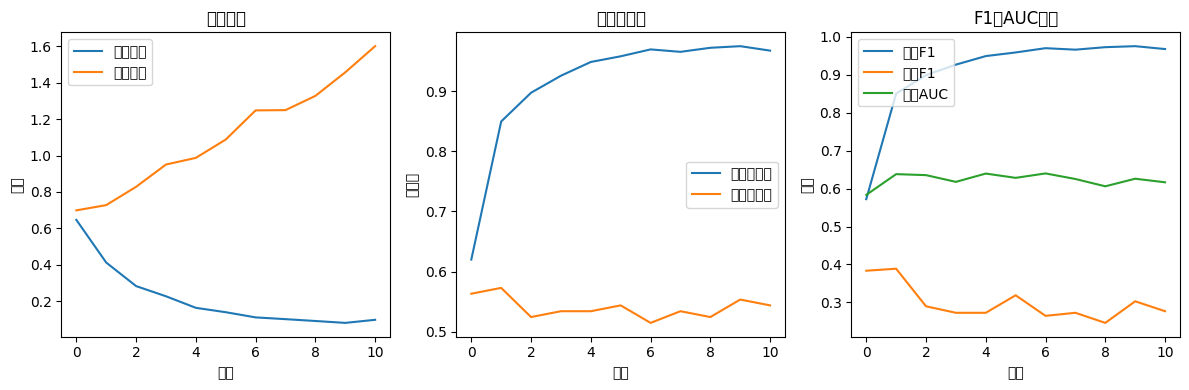

In [368]:
# 绘制训练曲线
import matplotlib.pyplot as plt
# 中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 4))

# 损失曲线
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='训练损失')
plt.plot(history['val_loss'], label='验证损失')
plt.legend()
plt.title('损失曲线')
plt.xlabel('轮次')
plt.ylabel('损失')

# 准确率曲线
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='训练准确率')
plt.plot(history['val_acc'], label='验证准确率')
plt.legend()
plt.title('准确率曲线')
plt.xlabel('轮次')
plt.ylabel('准确率')

# F1和AUC曲线
plt.subplot(1, 3, 3)
plt.plot(history['train_f1'], label='训练F1')
plt.plot(history['val_f1'], label='验证F1')
plt.plot(history['val_auc'], label='验证AUC')
plt.legend()
plt.title('F1和AUC曲线')
plt.xlabel('轮次')
plt.ylabel('分数')

plt.tight_layout()
plt.show()



In [369]:
# 加载最佳模型
model.load_state_dict(best_model)

# 在测试集上评估
test_loss, test_acc, test_prec, test_recall, test_f1, test_auc, test_bacc, test_aucpr = validate(model, test_loader, criterion)
print("\n最终测试结果:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"BACC: {test_bacc:.4f}")
print(f"AUCPR: {test_aucpr:.4f}")
# To Fix

0.6842105263157895
0.2549019607843137

最终测试结果:
Loss: 0.6831
Accuracy: 0.5728
Precision: 0.6842
Recall: 0.2549
F1 Score: 0.3714
AUC: 0.6150
BACC: 0.5698
AUCPR: 0.6341
